#Lecture 5 (Part1)
---------------
## Simple Linear Regression (Chapter 3 ISL book)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
import scipy

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
sns.set_style('white')

## Load Datasets
Datasets available on http://faculty.marshall.usc.edu/gareth-james/ISL/

In [2]:
advertising = pd.read_csv('../data/Advertising.csv', usecols=[1,2,3,4])
advertising.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [3]:
credit = pd.read_csv('../data/Credit.csv', usecols=list(range(1,12)))
credit['Student2'] = credit.Student.map({'No':0, 'Yes':1})
credit.head(3)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,Student2
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333,0
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903,1
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580,0


In [4]:
auto = pd.read_csv('../data/Auto.csv', na_values='?').dropna()
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 391
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    int64  
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
 8   name          392 non-null    object 
 9   Manufacturer  392 non-null    object 
dtypes: float64(3), int64(5), object(2)
memory usage: 33.7+ KB


## Loss Functions

Let us take a quick look at the distribution of weights and compute summary statistics

mean: 2977.58
median: 2803.5
mode: ModeResult(mode=array([2200.]), count=array([28]))


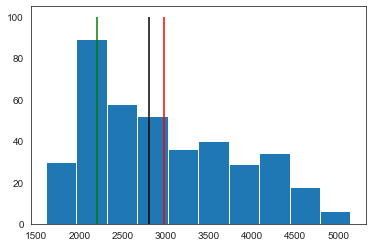

In [7]:
tmp=plt.hist(auto["weight"])
# LE = location estimate
LE1 = np.round(np.mean(auto["weight"]),2)
LE2 = np.round(np.median(auto["weight"]),2)
LE3 = scipy.stats.mode(np.round(auto["weight"]/100)*100)
plt.vlines(LE1,0,100, colors="red")
plt.vlines(LE2,0,100, colors="black")
plt.vlines(LE3[0],0,100, colors="green")

print("mean:",  LE1)
print("median:",  LE2)
print("mode:",  LE3)

We can see a marked difference between the mean and the median (why again?). 
That brings up the general question, how to choose from the various "location measures" of a distribution, such as the mean, median, trimmed mean, geometric mean, harmonic mean, ...


Can we define an objective optimality measure which would clearly favor one metric over another ? 
Welcome to the concept of a **loss function**.
We all feel intuitively that the orange line (at 3615 lb) is in some sense inferior to the red and green numbers as a location measure. Why, because the distance from the data to orange is (on the average) larger than the distance to red and green. Let us call that average distance a "loss" and assume that we want to **minimize loss**.

It turns out that there is not just one but various ways to define this distance/loss function ("LE" = location estimate):

1. $$ L_0 = (1/n) \cdot \sum_{i=1}^n{|x_i - LE|^0}$$
2. $$ L_1 = (1/n) \cdot \sum_{i=1}^n{|x_i - LE|^1}$$
3. $$ L_2 = (1/n) \cdot \sum_{i=1}^n{|x_i - LE|^2}$$
4. $$ L_p = (1/n) \cdot \sum_{i=1}^n{|x_i - LE|}^p$$

**Your Tasks:**

* Identify the one that is minimized by the average.
* Identify the one that is minimized by the median.
* Which measure is minimized by $L_0$ ? 
* Verify your assertions emprically !

In [39]:
def Lp(x,LE,p):
    return(np.mean(np.abs(x - LE)**p))

In [40]:
x_val = np.linspace(2500,3500,100)
LEs = [LE1, LE2, LE3]

MSEs = np.empty((x_val.shape[0],3)) #errors, model, func

for i, x in enumerate(x_val):
    MSEs[i,0]=Lp(auto["weight"], x, 0)
    MSEs[i,1]=Lp(auto["weight"], x, 1)
    MSEs[i,2]=Lp(auto["weight"], x, 2)
    


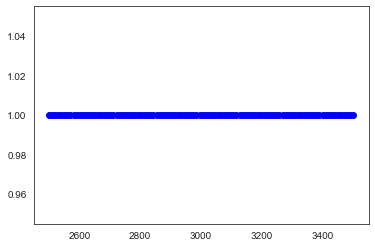

In [44]:
plt.scatter(x_val, MSEs[:,0], color="blue")

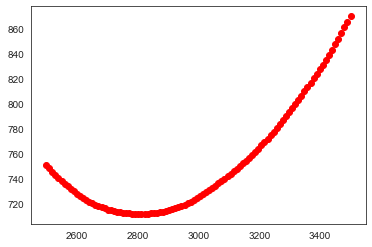

In [45]:
plt.scatter(x_val, MSEs[:,1], color="red")

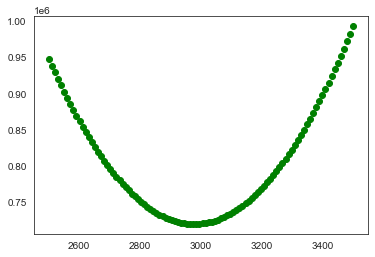

In [46]:
plt.scatter(x_val, MSEs[:,2], color="green")

In [38]:
print("mean:",  LE1)
print("median:",  LE2)
print("mode:",  LE3)

mean: 2977.58
median: 2803.5
mode: ModeResult(mode=array([2200.]), count=array([28]))


In [35]:
MSEs.argmin(axis=0)

array([ 0, 30, 47])

In [36]:
x_val[30]

2803.030303030303

In [37]:
x_val[47]

2974.747474747475

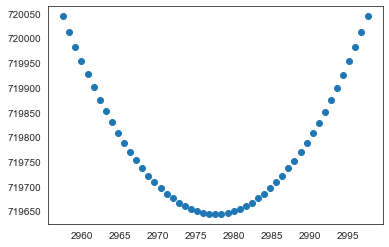

In [6]:
def L2(x,LE):
    return(np.mean((x - LE) * (x - LE)))
    
xg = np.linspace(LE1-20, LE1 +20, 51)
MSE = np.empty_like(xg) 
for i, a in enumerate(xg):
    MSE[i]= L2(auto["weight"], a)

tmp=plt.scatter(xg,MSE)

## Simple Linear Regression

Loss Function = squared residuals !

**Least Squares** equals minimizing $RSS = \sum_{i=1}^n{u_i^2}$

* Remind yourself of the definition of the slope of a straight line

<div>
<img src="../figures/SlopeIllustration.png" width="400"/>
</div>

$$
\beta_1 = \frac{\Delta y}{\Delta x} =  \frac{y_2-y_1}{x_2-x_1}
$$

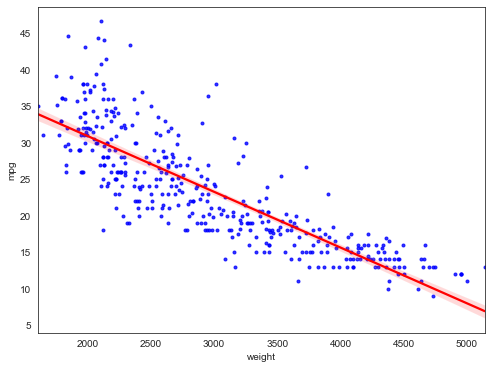

In [43]:
plt.figure(figsize=(8,6))
tmp=sns.regplot(x=auto["weight"], y=auto["mpg"], order=1, ci=95, 
                scatter_kws={'color':'b', 's':9}, line_kws={'color':'r'})

[sklearn does not seem to offer even standard errors!](https://stackoverflow.com/questions/22381497/python-scikit-learn-linear-model-parameter-standard-error)

Module **statsmodels** gives output closer in line with other statistical software:

In [8]:
est = smf.ols('mpg ~ weight', auto).fit() #  y ~ x 
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,46.2165,0.799,57.867,0.000,44.646,47.787
weight,-0.0076,0.000,-29.645,0.000,-0.008,-0.007


In [9]:
est = smf.ols('mpg ~ C(origin) + weight', auto).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,43.7322,1.113,39.277,0.000,41.543,45.921
C(origin)[T.2],0.9709,0.659,1.474,0.141,-0.324,2.266
C(origin)[T.3],2.3271,0.665,3.501,0.001,1.020,3.634
weight,-0.0070,0.000,-21.956,0.000,-0.008,-0.006


In [10]:
est = smf.ols('Sales ~ Newspaper', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,12.3514,0.621,19.876,0.000,11.126,13.577
Newspaper,0.0547,0.017,3.300,0.001,0.022,0.087


In [11]:
est = smf.ols('mpg ~ horsepower', auto).fit()
est.summary(alpha=0.01).tables[1]

,coef,std err,t,P>|t|,[0.005,0.995]
Intercept,39.9359,0.717,55.660,0.000,38.079,41.793
horsepower,-0.1578,0.006,-24.489,0.000,-0.175,-0.141


In [12]:
from scipy.stats import t
tC =t.ppf(0.995,390)#2.588
-0.1578 - tC*0.006
#-0.1578 + tC*0.006
est.conf_int(alpha = 0.01)

,0,1
Intercept,38.078620,41.793102
horsepower,-0.174529,-0.141161


--------------------------------------------------------
### Reproducing the ISL Book

In the following sections we are mainly reproducing figures and results from the ISL book.

**Figure 3.1 - Least squares fit**

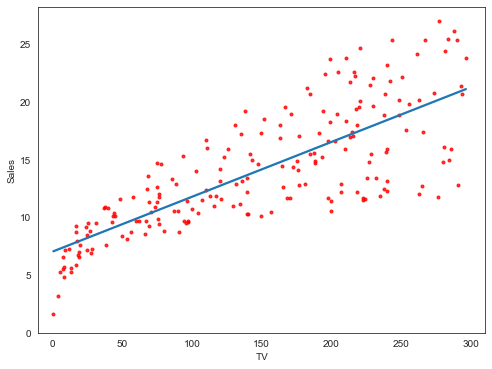

In [13]:
plt.figure(figsize=(8,6))
sns.regplot(x=advertising.TV, y=advertising.Sales, order=1, ci=None, scatter_kws={'color':'r', 's':9})
plt.xlim(-10,310)
plt.ylim(ymin=0);

**Figure 3.2 - Regression coefficients - RSS**
Note that the text in the book describes the coefficients based on uncentered data, whereas the plot shows the model based on centered data. The latter is visually more appealing for explaining the concept of a minimum RSS. I think that, in order not to confuse the reader, the values on the axis of the B0 coefficients have been changed to correspond with the text. The axes on the plots below are unaltered.

In [14]:
np.corrcoef(advertising.TV, advertising.Sales)

array([[1.        , 0.78222442],
       [0.78222442, 1.        ]])

In [15]:
#what data structures does the fit function want?
X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
y = np.dot(X, np.array([1, 2])) + 3
reg = skl_lm.LinearRegression().fit(X, y)
reg.coef_
type(advertising.Sales)

pandas.core.series.Series

In [16]:
# Regression coefficients (Ordinary Least Squares)
regr = skl_lm.LinearRegression()

#X = scale(advertising.TV, with_mean=True, with_std=False).reshape(-1,1)
X=advertising.TV.values.reshape(-1,1)
X = scale(advertising.TV, with_mean=True, with_std=False).reshape(-1,1)

y = advertising.Sales.values

regr.fit(X,y)
print(regr.intercept_)
print(regr.coef_)

14.0225
[0.04753664]


**Tasks**

1. Compute the residuals, their sum and RSS (are they different for non-centered X?)
2. Compute $R^2$ and compare with the correlation coefficient $\rho$.
3. Interpret the meaning of the slope $\hat{\beta_1}$.
4. Obtain $SE(\hat{\beta_1})$ and a 95% confidence interval for the slope.
5. Discuss how one could use resampling to obtain non-parametric confidence intervals
6. (homework) Test whether the true slope could be 0.

#### Least Squares

Is RSS really minimized ?

In [17]:
# Minimized RSS
min_rss = np.sum((regr.intercept_+regr.coef_*X - y.reshape(-1,1))**2)/1000
min_rss

2.1025305831313514

<img src="../figures/RSS - Regression coefficients.png" width="1000"/>

#### Confidence interval on page 67 & Table 3.1 & 3.2 - Statsmodels

In [18]:
est = smf.ols('Sales ~ TV', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.0326,0.458,15.360,0.000,6.130,7.935
TV,0.0475,0.003,17.668,0.000,0.042,0.053


In [19]:
# RSS with regression coefficients
((advertising.Sales - (est.params[0] + est.params[1]*advertising.TV))**2).sum()/1000

2.1025305831313514

**Table 3.1 & 3.2 - Scikit-learn**
<table>
    <tr>
        <td>
            <img src="../figures/ISLR-Table3-1.png" width="600"/>
        </td>
        <td>
            <img src="../figures/ISLR-Table3-2.png" width="600"/>
        </td>
    </tr>
</table>

In [20]:
regr = skl_lm.LinearRegression()

X = advertising.TV.values.reshape(-1,1)
y = advertising.Sales

regr.fit(X,y)
print(regr.intercept_)
print(regr.coef_)

7.032593549127693
[0.04753664]


In [21]:
Sales_pred = regr.predict(X)
r2_score(y, Sales_pred)

0.611875050850071